##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

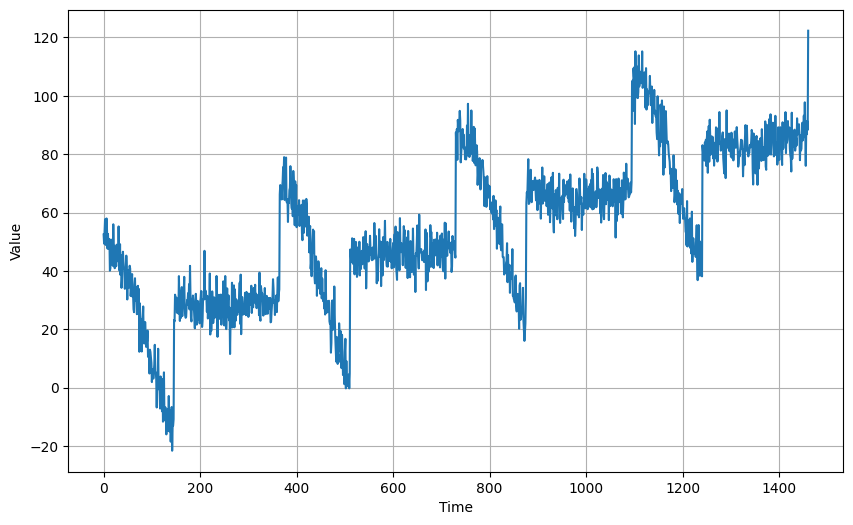

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.learning_rate.numpy()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule,LearningRateLogger()]) # Add the LearningRateLogger callback here

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 71.7570 - mae: 72.2566 - learning_rate: 1.0000e-08 - lr: 1.0000e-08
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 69.9189 - mae: 70.4185 - learning_rate: 1.1220e-08 - lr: 1.1220e-08
Epoch 3/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 70.2617 - mae: 70.7613 - learning_rate: 1.2589e-08 - lr: 1.2589e-08
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 68.8503 - mae: 69.3499 - learning_rate: 1.4125e-08 - lr: 1.4125e-08
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 68.4610 - mae: 68.9607 - learning_rate: 1.5849e-08 - lr: 1.5849e-08
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 66.4073 - mae: 66.9067 - learning_rate: 1.7783e-08 - lr: 1.7783e-08
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 65.3243 - mae: 65.8239 - learning_rate: 1.9953e-08 - lr: 1.9953e-08
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 63.3061 - mae: 63.8056 - learning_rate: 2.2387e-08 - lr: 2.2387e-08
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 61.3577 - mae: 61.8570 - learning_rate: 2.5119e-08 - lr: 2.5119e-08
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 59.9292 - mae: 60.4287 - learning_rate: 2.8184e-08 - lr: 2.8184e-08
Epoch 11/

(np.float64(1e-08), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

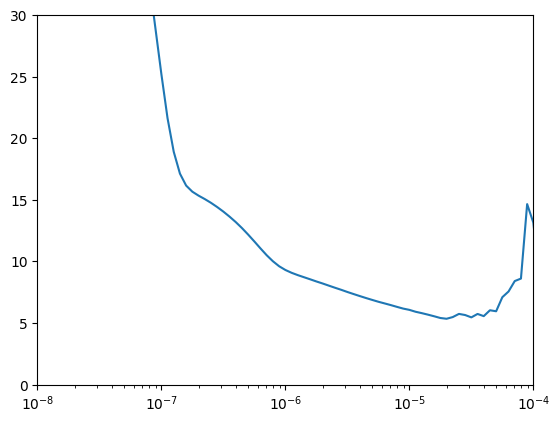

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 25.1855 - mean_absolute_error: 25.6809 - val_loss: 37.0620 - val_mean_absolute_error: 37.5616
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 15.9495 - mean_absolute_error: 16.4419 - val_loss: 23.7969 - val_mean_absolute_error: 24.2943
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10.2057 - mean_absolute_error: 10.6936 - val_loss: 17.9827 - val_mean_absolute_error: 18.4774
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.8663 - mean_absolute_error: 9.3532 - val_loss: 14.5261 - val_mean_absolute_error: 15.0187
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6458 - mean_absolute_error: 8.1309 - val_loss: 13.9337 - val_mean_absolute_error: 14.4256
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.0755 - mean_absolute_error: 7.5597 - val_loss: 15.8214 - val_mean_absolute_error: 16.3170
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.5499 - mean_absolute_error: 7.0314

In [9]:
# error code: model = keras.models.load_model("my_checkpoint.keras")
# set safe_mode=False or define a custom_objects dictionary
model = keras.models.load_model("my_checkpoint.keras", custom_objects={'lambda': lambda x: x * 200}, safe_mode=False)

In [10]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


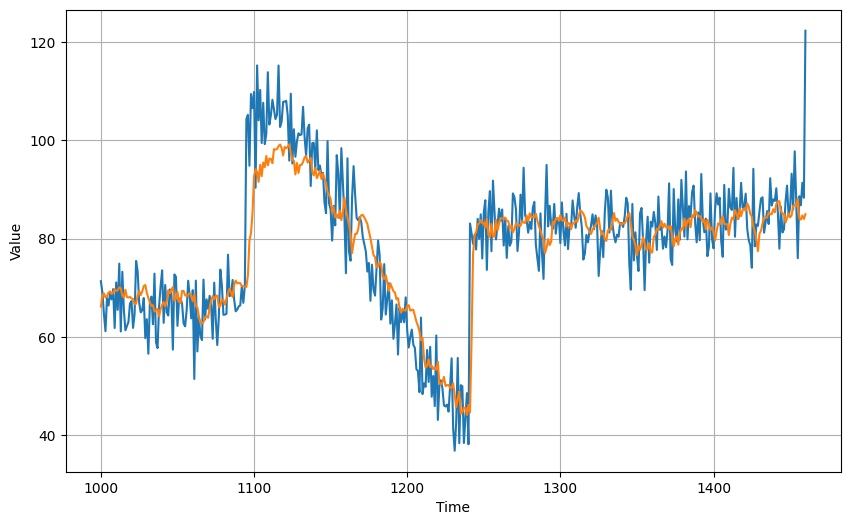

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
import tensorflow as tf

# Assuming 'x_valid' and 'rnn_forecast' are NumPy arrays or TensorFlow tensors
mae = tf.keras.metrics.MeanAbsoluteError()(x_valid, rnn_forecast).numpy()
print(mae)

5.340053


## Fully Convolutional Forecasting

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - loss: 42.9658 - mean_absolute_error: 43.4646 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42.5083 - mean_absolute_error: 43.0070 - learning_rate: 1.0798e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41.7601 - mean_absolute_error: 42.2588 - learning_rate: 1.1659e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42.6342 - mean_absolute_error: 43.1331 - learning_rate: 1.2589e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42.4088 - mean_absolute_error: 42.9077 - learning_rate: 1.3594e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41.8746 - mean_absolute_error: 42.3737 - learning_rate: 1.4678e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41.5976 - mean_absolute_error: 42.0968 - learning_rate: 1.5849e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 40.3769 - mean_absolute_error: 40.8762 - learning_rate: 1.7113e-04
Epoch 9/100
8/8 ━━

(np.float64(0.0001), np.float64(0.1), np.float64(0.0), np.float64(30.0))

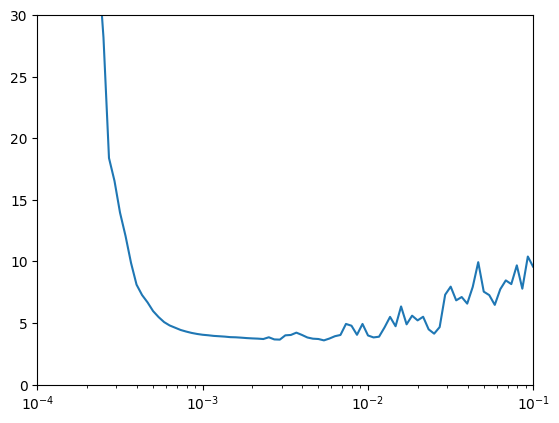

In [14]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
# The optimal learning rate can be inferred from previous runs
optimizer = keras.optimizers.Adam(learning_rate=3e-4) # replace with optimal lr
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step - loss: 40.6155 - mean_absolute_error: 41.1145 - val_loss: 73.4147 - val_mean_absolute_error: 73.9147
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 38.6801 - mean_absolute_error: 39.1788 - val_loss: 68.5175 - val_mean_absolute_error: 69.0175
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 35.3613 - mean_absolute_error: 35.8598 - val_loss: 60.9736 - val_mean_absolute_error: 61.4736
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 31.9258 - mean_absolute_error: 32.4242 - val_loss: 49.5996 - val_mean_absolute_error: 50.0994
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 25.7041 - mean_absolute_error: 26.2013 - val_loss: 34.6766 - val_mean_absolute_error: 35.1733
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 19.4787 - mean_absolute_error: 19.9726 - val_loss: 29.6635 - val_mean_absolute_error: 30.1595
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 17.9608 - mean_absolute_error

In [16]:
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False)

In [17]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


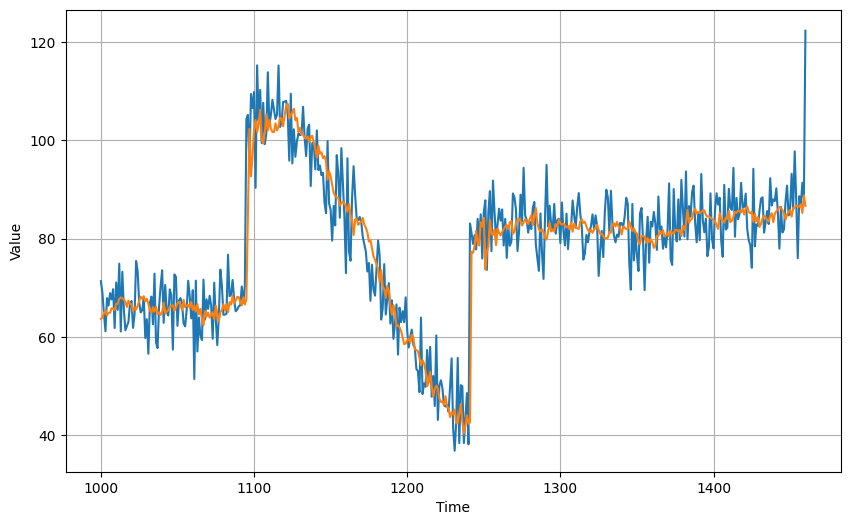

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [19]:
#error code: keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()
mae = tf.keras.metrics.MeanAbsoluteError()(x_valid, cnn_forecast).numpy()
print(mae)

4.6266527
